## Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных на тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево
### Ссылки
https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0 <br>
https://habr.com/ru/company/ru_mts/blog/485980/#reference1 <br>
https://en.wikipedia.org/wiki/Uplift_modelling <br>
https://www.youtube.com/watch?v=yFQAIJBYXI0 <br>
https://www.youtube.com/watch?v=jCUcYiBK03I <br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#?plot_uplift_preds

In [3]:
def my_plot_uplift_preds(trmnt_preds, ctrl_preds, log=False, bins=100):
    plt.figure(figsize=(16,7))
    
    plt.subplot(1,3,1)
    plt.hist(trmnt_preds, bins=bins, log=log, color='royalblue', label='Treated')
    plt.ylabel('Probability hist')
    plt.legend()
    plt.title('Treatment predictions')
    
    plt.subplot(1,3,2)
    plt.hist(ctrl_preds, bins=bins, log=log, color='khaki', label='Not treated')
    plt.xlabel('Probability')
    plt.legend()
    plt.title('Control predictions')
    
    plt.subplot(1,3,3)
    uplift_preds = trmnt_preds - ctrl_preds
    plt.hist(uplift_preds, bins=bins, log=log, color='yellowgreen', label='Uplift')
    plt.legend()
    plt.title('Uplift predictions')
    plt.show()

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [4]:
train_data = pd.read_csv('data.csv')
print(train_data.shape)
train_data.head(3)

(64000, 9)


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
offer            64000 non-null object
conversion       64000 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [6]:
train_data = train_data.rename(columns={'conversion': 'target', 'offer': 'treatment'})
train_data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [7]:
train_data['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [8]:
train_data['treatment'] = list(map(lambda x: 0 if x=='No Offer' else 1, train_data['treatment']))
train_data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


3. сделать разбиение набора данных на тренировочную и тестовую выборки

In [9]:
indices_learn, indices_valid = train_test_split(train_data.index, test_size=0.3, random_state=123)
display(indices_learn, indices_valid)

Int64Index([53181, 42635,  6296, 41722, 32660, 14730, 40469, 49818, 51773,
            34850,
            ...
            63594,  7763, 15377, 63206, 54370, 61404, 17730, 28030, 15725,
            52734],
           dtype='int64', length=44800)

Int64Index([19593,  4997, 36682, 29881, 25401, 41888,  4353, 33487, 63951,
            35285,
            ...
            41382, 46836, 36489, 13683, 10904, 39655, 45479, 21007, 39923,
            61435],
           dtype='int64', length=19200)

In [10]:
train_features = train_data.copy().drop(['target', 'treatment'], axis=1)
X_train = train_features.loc[indices_learn, :]
y_train = train_data.loc[indices_learn, 'target']
treat_train = train_data.loc[indices_learn, 'treatment']

X_test = train_features.loc[indices_valid, :]
y_test = train_data.loc[indices_valid, 'target']
treat_test =  train_data.loc[indices_valid, 'treatment']

X_train_full = train_features.loc[train_data.index, :]
y_train_full = train_data.loc[:, 'target']
treat_train_full = train_data.loc[:, 'treatment']

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [11]:
train_data.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
for feat in ['recency','history','used_discount','used_bogo','zip_code','is_referral','channel','treatment','target']:
    display(train_data[feat].value_counts())

1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: recency, dtype: int64

29.99     7947
81.20        9
53.79        9
142.94       8
35.40        8
          ... 
701.66       1
246.45       1
798.83       1
125.19       1
104.00       1
Name: history, Length: 34833, dtype: int64

1    35266
0    28734
Name: used_discount, dtype: int64

1    35182
0    28818
Name: used_bogo, dtype: int64

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

1    32144
0    31856
Name: is_referral, dtype: int64

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

1    42694
0    21306
Name: treatment, dtype: int64

0    54606
1     9394
Name: target, dtype: int64

* zip_code, channel - категориальные - сделаем два варианта: с предобработкой и с передачей как есть в catboost
* history, recency - номинативные - можно масштабировать, но пока оставим как есть
* остальные бинарные оставим как есть

In [13]:
X_train_prep = pd.concat([X_train.drop(['zip_code', 'channel'], axis=1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_train['channel'], prefix='channel')
                         ], 1)
X_test_prep = pd.concat([X_test.drop(['zip_code', 'channel'], axis=1), 
                          pd.get_dummies(X_test['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_test['channel'], prefix='channel')
                         ], 1)

In [14]:
cat_features = ['zip_code', 'channel']
cat_features_prep = []

In [15]:
classifier = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [16]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### Одна модель с признаком коммуникации

array([0.15441666, 0.3002941 , 0.07317553, ..., 0.20309238, 0.2629657 ,
       0.13758629])

array([0.13205418, 0.30224907, 0.04808879, ..., 0.14006086, 0.14410345,
       0.10961068])

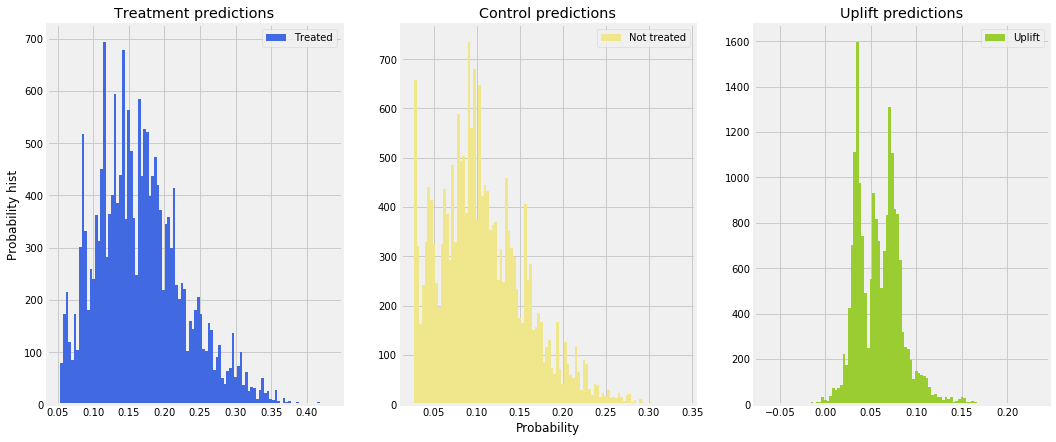

In [17]:
# Без предварительной обработки категориальных
sm = SoloModel(classifier)
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
#plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);
display(sm_trmnt_preds,sm_ctrl_preds)
my_plot_uplift_preds(sm_trmnt_preds, sm_ctrl_preds)

In [18]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.189426
1,treatment,17.927079
2,used_bogo,12.651803
3,recency,11.793690
4,channel,11.197806
5,zip_code,9.776886
6,used_discount,8.943366
7,history,8.519945


array([0.16638341, 0.3046927 , 0.06799638, ..., 0.22599402, 0.25485516,
       0.13782817])

array([0.14114531, 0.36039453, 0.03644583, ..., 0.18155732, 0.16807569,
       0.11999468])

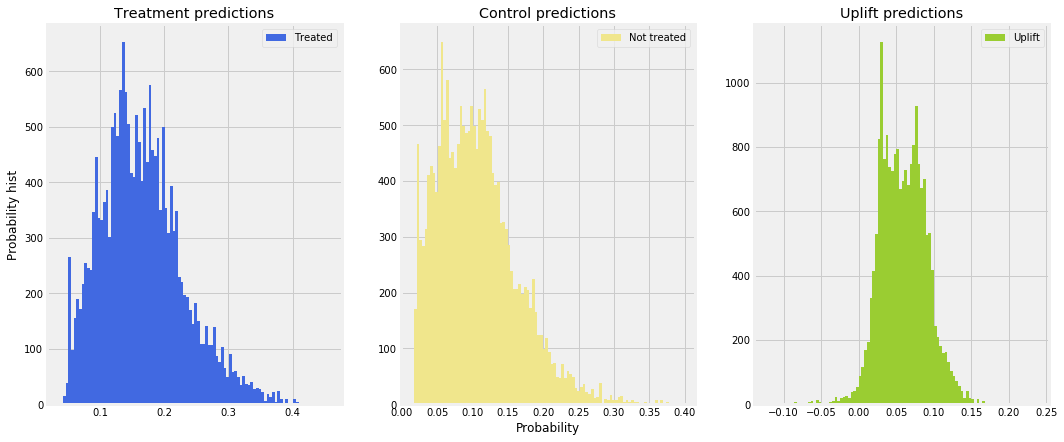

In [19]:
# С предварительной обработкой категориальных
sm = SoloModel(classifier)
sm = sm.fit(X_train_prep, y_train, treat_train, estimator_fit_params={'cat_features': cat_features_prep})

uplift_sm = sm.predict(X_test_prep)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel_prep_cat')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds_prep = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds_prep = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
#plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);
display(sm_trmnt_preds_prep,sm_ctrl_preds_prep)
my_plot_uplift_preds(sm_trmnt_preds_prep, sm_ctrl_preds_prep)

In [20]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,17.506427
1,treatment,16.255747
2,history,15.471143
3,recency,14.464657
4,used_bogo,10.703624
5,used_discount,7.988503
6,channel_Web,6.794430
7,zip_code_Rural,6.018450
8,zip_code_Urban,1.569307
9,zip_code_Surburban,1.296216


#### Трансформация классов

In [21]:
# Без предварительной обработки категориальных
classifier = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)

ct = ClassTransformation(classifier)
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [22]:
# С предварительной обработкой категориальных
classifier = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)

ct = ClassTransformation(classifier)
ct = ct.fit(X_train_prep, y_train, treat_train, estimator_fit_params={'cat_features': cat_features_prep})

uplift_ct = ct.predict(X_test_prep)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation_prep_cat')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

#### Две независимые модели

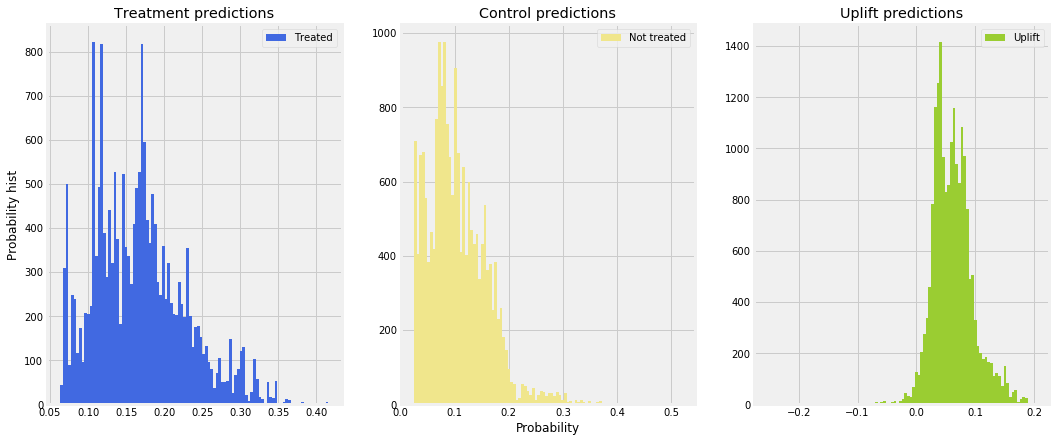

In [23]:
# Без предварительной обработки категориальных
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

my_plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

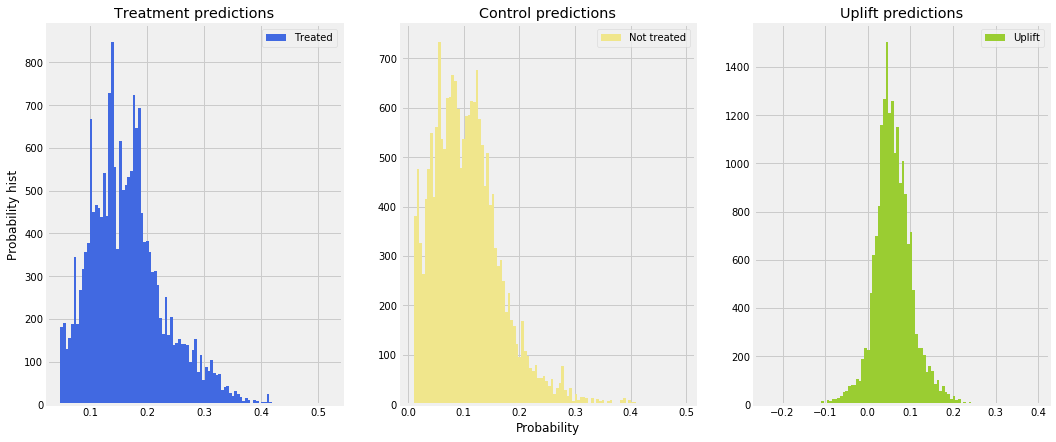

In [24]:
# С предварительной обработкой категориальных
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train_prep, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features_prep}, 
    estimator_ctrl_fit_params={'cat_features': cat_features_prep}
)

uplift_tm = tm.predict(X_test_prep)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels_prep_cat')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

my_plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [25]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,ClassTransformation,0.117411,0.095800
1,SoloModel_prep_cat,0.093145,0.087191
0,SoloModel,0.089254,0.078994
5,TwoModels_prep_cat,0.085339,0.077817
4,TwoModels,0.078306,0.068439
3,ClassTransformation_prep_cat,0.072844,0.071572


Интересный результат получился - в зависимости от предобработки категориальных переменных, ClassTransformation показал кардинально отличающиеся результаты. 

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [26]:
X_train_tree = X_train_prep.copy()
features = [col for col in X_train_tree]
X_train_tree.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
53181,8,121.56,0,1,0,0,1,0,0,0,1
42635,9,617.62,0,1,1,0,0,1,0,1,0
6296,5,185.62,1,0,1,1,0,0,0,0,1
41722,1,359.03,0,1,0,1,0,0,0,0,1
32660,10,139.68,1,0,0,0,0,1,0,0,1


CPU times: user 4.53 s, sys: 112 ms, total: 4.64 s
Wall time: 5.38 s


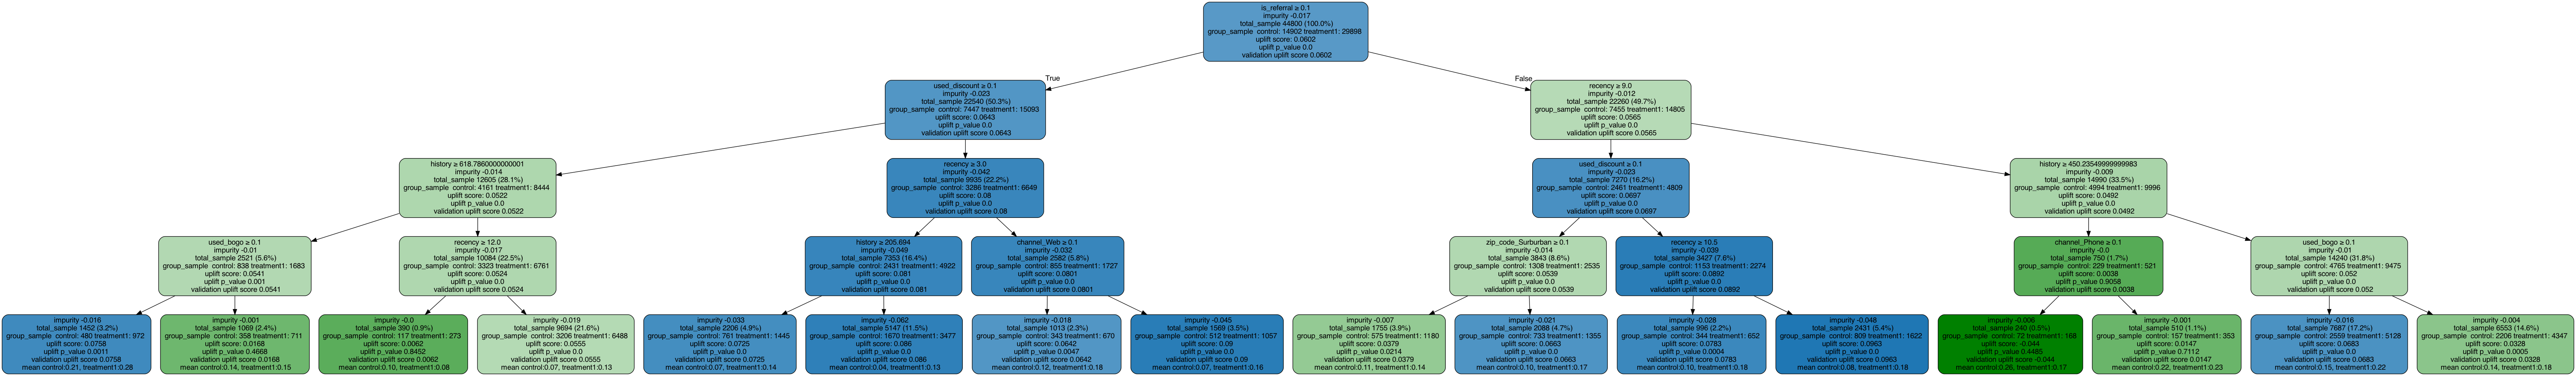

In [27]:
%%time
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Сделала глубину дерева 5 в надежде, что его будет проще  интерпретировать.
Самый первый в дереве и, как показал SoloModel, самый важный признак is_referral. 
Во всех листах, где выборка с коммуникацией и контрольная статистически различимы(p-value<0.05), mean treatment больше, чем control, то есть, если я правильно понимаю, независимо от значений признаков, польза при коммуникации больше, чем при ее отсутствии. То есть в данном дотаяете у нас видимо нет пользователей типа «sleeping dogs». 
Еще что-то сложно сказать, так как, если бы у нас были листья, где на контроле показатели были бы больше, можно было бы попробовать как-то составить портрет пользователя. А у нас таких вроде нет(статистически значимых). 